In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pickle
import datetime

In [2]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [3]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [4]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [5]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [6]:
# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# LabelEncoding

# cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

del cat_cols

# Onep-Hot-Encoding

cat_cols = ['cylinders', 'model year', 'origin', 'car name', 'car_brand']
train_test = pd.get_dummies(
    train_test,
    columns=cat_cols, 
    sparse=False
)

display(train_test)

# Drop unimportant features

In [7]:
train_test.drop(['car name', 'car_brand'], axis=1, inplace=True)
display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,23.059782,6,140,110.0,2815,17.977429,80,1
1,3,17.674521,8,350,150.0,4456,13.514535,72,1
2,4,17.136353,8,302,140.0,2774,13.209912,79,1
3,7,22.664666,6,400,85.0,2190,15.196381,71,1
4,9,17.872018,8,429,220.0,2245,9.621400,70,1
...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,225,105.0,3870,15.376311,76,1
996,993,NaN,4,140,112.0,2720,13.616843,82,1
997,996,NaN,8,318,110.0,2774,13.272636,75,1
998,998,NaN,4,90,75.0,2807,17.792560,77,1


# Create Model 

In [8]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_x = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [10]:
print("tr_x:", tr_x.shape)
print("tr_y:", tr_y.shape)

print("va_x:", va_x.shape)
print("va_y:", va_y.shape)

tr_x: (400, 7)
tr_y: (400,)
va_x: (100, 7)
va_y: (100,)


In [11]:
class MLP:

    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None

    def fit(self, tr_x, tr_y, va_x, va_y):

        # パラメータ
        input_dropout = self.params['input_dropout']
        hidden_layers = int(self.params['hidden_layers'])
        hidden_units = int(self.params['hidden_units'])
        hidden_activation = self.params['hidden_activation']
        hidden_dropout = self.params['hidden_dropout']
        batch_norm = self.params['batch_norm']
        optimizer_type = self.params['optimizer']['type']
        optimizer_lr = self.params['optimizer']['lr']
        batch_size = int(self.params['batch_size'])

        # 標準化
        self.scaler = StandardScaler()
        tr_x = self.scaler.fit_transform(tr_x)
        va_x = self.scaler.transform(va_x)

        # Layer Setting
        self.model = Sequential()
        self.model.add(Dropout(input_dropout, input_shape=(tr_x.shape[1],)))# 入力層
        for i in range(hidden_layers):# 中間層
            self.model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                self.model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                self.model.add(PReLU())
            elif hidden_activation == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(hidden_dropout))
        self.model.add(Dense(1))# 出力層

        # オプティマイザ
        if optimizer_type == 'sgd':
            optimizer = SGD(lr=optimizer_lr, decay=1e-6, momentum=0.9, nesterov=True)
        elif optimizer_type == 'adam':
            optimizer = Adam(lr=optimizer_lr, beta_1=0.9, beta_2=0.999, decay=0.)
        else:
            raise NotImplementedError

        # 目的関数、評価指標などの設定
        self.model.compile(loss='mean_squared_error',
                           optimizer=optimizer, metrics=['mse'])

        # エポック数、アーリーストッピング
        # あまりepochを大きくすると、小さい学習率のときに終わらないことがあるので注意
        nb_epoch = 200
        patience = 20
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=batch_size, verbose=0,
                                 validation_data=(va_x, va_y),
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred


In [12]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(params):    
    model = MLP(params)
    model.fit(tr_x, tr_y, va_x, va_y)
    va_pred = model.predict(va_x)
    score = RMSE(va_y, va_pred)
    print(f'params:{params} \n RMSE:{score:.4f}')
    
    history.append((params, score))
    
    return {
        'loss':score,
        'status':STATUS_OK,
        'params':params
    }

In [13]:
base_param = {
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 96,
    'hidden_activation': 'relu',
    'hidden_dropout': 0.2,
    'batch_norm': 'before_act',
    'optimizer': {'type': 'adam', 'lr': 0.001},
    'batch_size': 64,
}

# default param space
param_space ={
    'batch_norm': hp.choice(
        label='batch_norm', options=['no', 'before_act'], 
    ),
    'batch_size': hp.quniform(label='batch_size', low=10, high=100, q=16),
    'hidden_activation': hp.choice(label='hidden_activation', options=['prelu', 'relu']),
    'hidden_dropout': hp.quniform(label='hidden_dropout', low=0.05, high=0.4, q=0.05),
    'hidden_layers': hp.quniform(label='hidden_layers', low=3, high=4, q=1),
    'hidden_units': hp.quniform(label='hidden_units', low=200, high=320, q=16),
    'input_dropout': hp.quniform(label='input_dropout', low=0.1, high=0.4, q=0.025),
    'optimizer': hp.choice(
        label='optimizer',
        options=[{'type': 'adam',
                  'lr': hp.loguniform(
                      label='adam_lr', low=np.log(0.0001), high=np.log(0.01)
                  )},
                 {'type': 'sgd', 
                 'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}
                ])
}

In [22]:
param_space ={
    'batch_norm': hp.choice(
        label='batch_norm', options=['no'], 
    ),
    'batch_size': hp.quniform(label='batch_size', low=10, high=100, q=16),
    'hidden_activation': hp.choice(label='hidden_activation', options=['prelu', 'relu']),
    'hidden_dropout': hp.quniform(label='hidden_dropout', low=0.05, high=0.4, q=0.05),
    'hidden_layers': 4,#hp.quniform(label='hidden_layers', low=3, high=4, q=1),
    'hidden_units': hp.quniform(label='hidden_units', low=200, high=320, q=16),
    'input_dropout': hp.quniform(label='input_dropout', low=0.1, high=0.4, q=0.025),
    'optimizer': hp.choice(
        label='optimizer',
        options=[{'type': 'adam',
                  'lr': hp.loguniform(
                      label='adam_lr', low=np.log(0.0001), high=np.log(0.01)
                  )},
                 #{'type': 'sgd', 
                 #'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}
                ])
}

In [23]:
max_evals = 50
nn_trials = Trials()
history = []
best = fmin(objective, param_space, algo=tpe.suggest, trials=nn_trials, max_evals=max_evals)

params:{'batch_norm': 'no', 'batch_size': 16.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.2, 'hidden_layers': 4, 'hidden_units': 224.0, 'input_dropout': 0.17500000000000002, 'optimizer': {'lr': 0.0021393570497722243, 'type': 'adam'}} 
 RMSE:3.2311
params:{'batch_norm': 'no', 'batch_size': 16.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.30000000000000004, 'hidden_layers': 4, 'hidden_units': 272.0, 'input_dropout': 0.225, 'optimizer': {'lr': 0.001849934210546057, 'type': 'adam'}} 
 RMSE:3.4628
params:{'batch_norm': 'no', 'batch_size': 96.0, 'hidden_activation': 'relu', 'hidden_dropout': 0.25, 'hidden_layers': 4, 'hidden_units': 240.0, 'input_dropout': 0.35000000000000003, 'optimizer': {'lr': 0.0015021828215194474, 'type': 'adam'}} 
 RMSE:4.0999
params:{'batch_norm': 'no', 'batch_size': 16.0, 'hidden_activation': 'prelu', 'hidden_dropout': 0.1, 'hidden_layers': 4, 'hidden_units': 272.0, 'input_dropout': 0.2, 'optimizer': {'lr': 0.0009197573302213211, 'type': 'adam'}} 
 RMS

,loss,batch_norm,batch_size,hidden_activation,hidden_dropout,hidden_layers,hidden_units,input_dropout,optimizer
0,3.173336,no,16.0,relu,0.35,4,240.0,0.175,"{'lr': 0.0040487643857661055, 'type': 'adam'}"
1,3.203618,no,48.0,relu,0.25,4,208.0,0.200,"{'lr': 0.006679635703610974, 'type': 'adam'}"
2,3.231136,no,16.0,prelu,0.20,4,224.0,0.175,"{'lr': 0.0021393570497722243, 'type': 'adam'}"
3,3.238207,no,32.0,relu,0.25,4,240.0,0.250,"{'lr': 0.0031179983274492546, 'type': 'adam'}"
4,3.265314,no,32.0,prelu,0.25,4,208.0,0.100,"{'lr': 0.0028606398175625943, 'type': 'adam'}"
5,3.268028,no,64.0,prelu,0.05,4,224.0,0.125,"{'lr': 0.0019842694481507226, 'type': 'adam'}"
6,3.286436,no,32.0,relu,0.40,4,272.0,0.150,"{'lr': 0.007058353804021013, 'type': 'adam'}"
7,3.289683,no,48.0,prelu,0.15,4,240.0,0.125,"{'lr': 0.005916930615513149, 'type': 'adam'}"
8,3.297353,no,16.0,relu,0.30,4,208.0,0.175,"{'lr': 0.009818184433757517, 'type': 'adam'}"
9,3.298096,no,64.0,prelu,0.25,4,224.0,0.150,"{'lr': 0.0026310160245554353, 'type': 'adam'}"


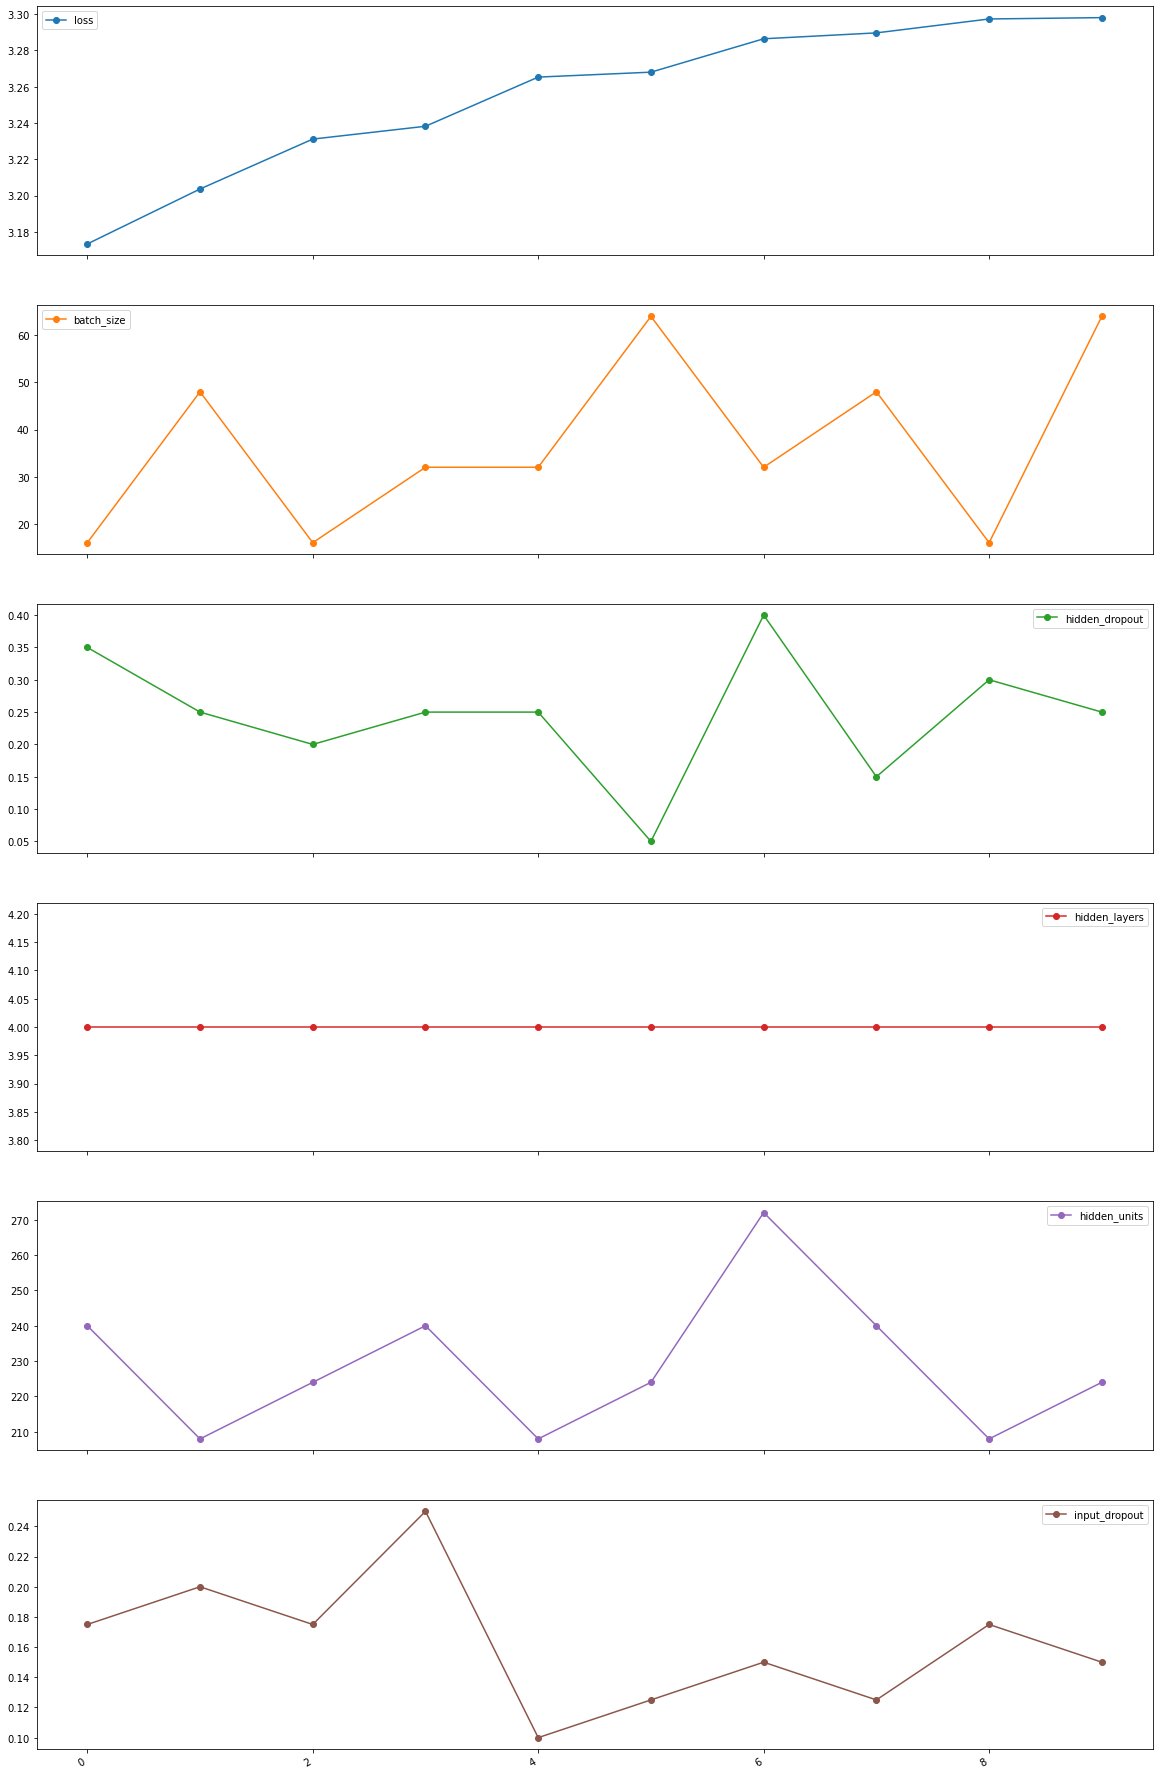

In [24]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(nn_trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df[:10])

opt_params_df.iloc[:10, :].plot.line(figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True)
plt.show()

In [25]:
best_loss = losses[0]
best_params = opt_params[0]

print("best_loss: ")
pprint.pprint(best_loss)
print("\nbest_params: ")
pprint.pprint(best_params)

best_loss: 
3.1733363103114534

best_params: 
{'batch_norm': 'no',
 'batch_size': 16.0,
 'hidden_activation': 'relu',
 'hidden_dropout': 0.35000000000000003,
 'hidden_layers': 4,
 'hidden_units': 240.0,
 'input_dropout': 0.17500000000000002,
 'optimizer': {'lr': 0.0040487643857661055, 'type': 'adam'}}


# Create Submission

In [26]:
best_model = MLP(best_params)
best_model.fit(tr_x, tr_y, va_x, va_y)
score = RMSE(va_y, best_model.predict(va_x))
pprint.pprint(best_params)
print(f'RMSE:{score:.4f}')

pred = best_model.predict(test_treated.drop(['id', 'mpg'], axis=1))

{'batch_norm': 'no',
 'batch_size': 16.0,
 'hidden_activation': 'relu',
 'hidden_dropout': 0.35000000000000003,
 'hidden_layers': 4,
 'hidden_units': 240.0,
 'input_dropout': 0.17500000000000002,
 'optimizer': {'lr': 0.0040487643857661055, 'type': 'adam'}}
RMSE:3.4331


In [27]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})

submission = pd.concat(
    [submission, pd.Series(pred, name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,33.796623
1,2,29.165413
2,5,29.588724
3,6,28.815947
4,8,29.977077
...,...,...
495,992,25.434584
496,993,27.545822
497,996,18.845682
498,998,29.598421


# Save Files

In [28]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_nn_carname_drop.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_nn_carname_drop.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_nn.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_nn.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '_nn.pickle', 'wb'))
# best train score
pickle.dump(score, open('../logs/train_score_' + dt + '_nn.pickle', 'wb'))

# Feature Importance

In [29]:
from collections import defaultdict
from sklearn.model_selection import KFold

In [30]:
def permuted(df):
    for col in df.columns:
        permuted_df = df.copy()
        permuted_df[col] = np.random.permutation(permuted_df[col])
        yield col, permuted_df

In [37]:
def pimp(clf, x, y, kf=None, eval_func=RMSE):
    base_scores=[]
    perm_scores = defaultdict(list)
    
    if kf is None:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for tr_idx, va_idx in kf.split(x, y):
        tr_x, tr_y = x.iloc[tr_idx], y.iloc[tr_idx]
        va_x, va_y = x.iloc[va_idx], y.iloc[va_idx]
        
        clf.fit(tr_x, tr_y, va_x, va_y)
        
        y_pred_base = clf.predict(va_x)
        base_score = eval_func(va_y, y_pred_base)
        base_scores.append(base_score)
        
        perm_va_x_gen = permuted(va_x)
        for col, perm_va_x in perm_va_x_gen:
            y_pred_perm = clf.predict(perm_va_x)
            perm_score = eval_func(va_y, y_pred_perm)
            perm_scores[col].append(perm_score)
            
    np_base_score = np.array(base_score)
    dict_perm_score = {name:np.array(scores) for name, scores in perm_scores.items()}
    return np_base_score, dict_perm_score

In [32]:
def score_diff_stat(base, perm):
    mean_base_score = base.mean()
    for col, scores in perm.items():
        score_diff = scores - mean_base_score
        yield col, score_diff.mean(), score_diff.std()
# score_diff.std()が0になってしまう？

In [38]:
# Permutation Importanceを計算
base_score, perm_scores = pimp(best_model, train_x, train_y)
pprint.pprint(perm_scores)

{'acceleration': array([4.58180752, 4.13170062, 3.64875636, 4.25508902, 4.64439101]),
 'cylinders': array([6.15201045, 4.78831715, 5.27908649, 6.22114856, 5.78607941]),
 'displacement': array([4.05491964, 3.36199794, 4.32484182, 3.81241011, 4.40723221]),
 'horsepower': array([4.45575625, 3.22095582, 3.4816878 , 3.5803703 , 4.17135086]),
 'model year': array([4.55748249, 3.73934926, 3.58280268, 3.91814087, 4.29292665]),
 'origin': array([4.21242291, 4.22350169, 4.48671352, 4.15057705, 4.26275742]),
 'weight': array([3.8276934 , 3.52846606, 3.4977149 , 3.75372181, 4.1841407 ])}


In [39]:
# カラム名、base scoreとの差、95%信頼区間を取り出す
diff_stat = list(score_diff_stat(base_score, perm_scores))
sorted_diff_stat = sorted(diff_stat, key=lambda x:x[1])
cols = [name for name, _, _ in sorted_diff_stat]
diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stat]
diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stat]

In [40]:
sorted_diff_stat

[('weight', -0.04624230027694578, 0.2477518658828883),
 ('horsepower', -0.022565468075699792, 0.45850934663682813),
 ('displacement', 0.18769067089868718, 0.3785010115628599),
 ('model year', 0.2135507158685681, 0.3587870446191074),
 ('acceleration', 0.447759231612611, 0.3580858764215354),
 ('origin', 0.46260484421666626, 0.11551355348339488),
 ('cylinders', 1.8407387391761738, 0.543453370442195)]

In [41]:
base_score

array(3.80458967)

findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


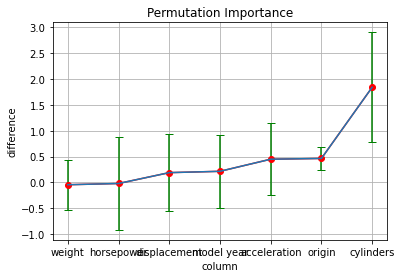

In [42]:
# グラフにプロットする
plt.plot(cols, diff_means, marker='o', color='r')
plt.errorbar(cols, diff_means, yerr=diff_stds_95, ecolor='g', capsize=4)

plt.title('Permutation Importance')
plt.grid()
plt.xlabel('column')
plt.ylabel('difference')
plt.show()